# **First** autoencoder

## Importing data

In [9]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.decomposition import PCA

from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt



#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

Real DATA

In [10]:
bigData = pd.read_csv("/Users/salati/Documents/CODE/AE2/DATA/Muscle_exon.txt", sep=" ")
#Taking only the rythmic genes
PeriodicData=bigData.loc[["ENSG00000105516", "ENSG00000049246", "ENSG00000167074", "ENSG00000174738", "ENSG00000179094", "ENSG00000132326" , "ENSG00000170485", "ENSG00000133794","ENSG00000126368","ENSG00000008405","ENSG00000121671","ENSG00000159208"]]
DATA=torch.tensor(PeriodicData.values)
DATA=DATA.float()
E=np.array(PeriodicData.values)

true_phases=pd.read_csv("/Users/salati/Documents/CODE/AE2/DATA/true_phi.txt",sep=" ")
true_phases=np.array(true_phases.values)
true_phases=true_phases[:,0]

Simulated DATA

N_Samples=56
N_PeriodicGenes=12
N_NonPeriodicGenes=0
N_Genes=N_PeriodicGenes+N_NonPeriodicGenes
NoiseSigma=0.04

#E , true_phases, alpha=NonUniformDataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes )
E , true_phases, alpha=DataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes , Means=False, NoiseSigma=NoiseSigma )

DATA=torch.from_numpy(E)
DATA=DATA.float()

In [11]:
N_Genes=DATA.shape[0]
N_Samples=DATA.shape[1]
N_Samples

57

Select gene you are interested setting varaible g in order to plot data, and supposed distribution

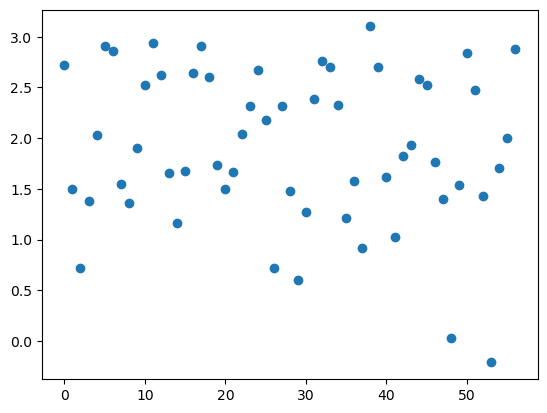

In [12]:
plt.plot(DATA[1,:], 'o')

## PCA

In [13]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

PCA(n_components=2)

In [14]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  3.469446951953614e-17


In [15]:
pca_points=pca.fit_transform(Et)

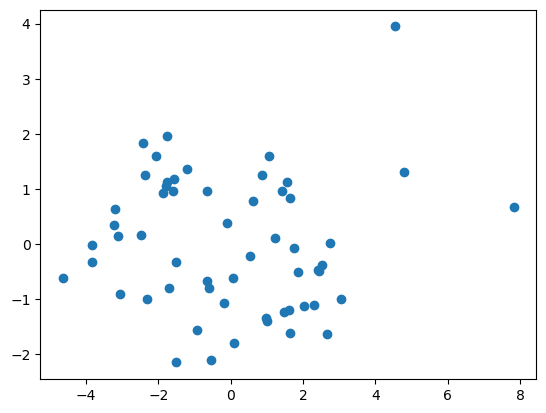

In [16]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [17]:
from DATA_generator import *
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])
PCAshifted_phi,madPCA=optimal_shift(PCA_phi, true_phases)
madPCA

0.33878580216853926

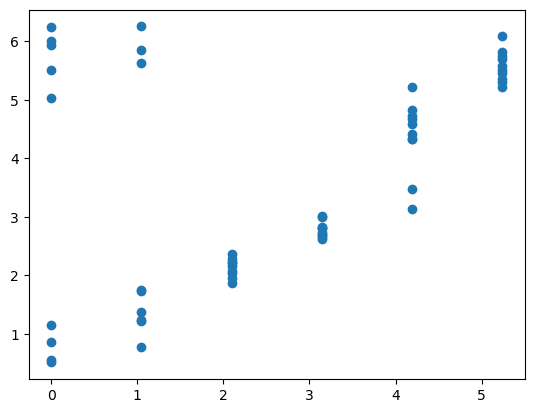

In [18]:
plt.plot(true_phases,PCAshifted_phi, 'o')

## Torch Linear

### Setting the network

In [19]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()
PCA_tensor

tensor([[-0.3415, -0.2836, -0.3255, -0.2395, -0.4008, -0.2304,  0.0701,  0.2681,
         -0.2792,  0.0499, -0.1431, -0.4982],
        [ 0.0096,  0.1267,  0.0540, -0.1128,  0.0749, -0.0783, -0.4529, -0.3995,
         -0.7616, -0.0944,  0.0129,  0.0511]])

In [20]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
           
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        decoded=self.decoder(encoded)

        return decoded

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [21]:
model = LinearEncoder()
criterion= nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00001)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


Adding the GPU stuff

In [22]:
#for GPU use this block

#device = torch.device('mps')
#E_t=torch.from_numpy(E)
#E_t=E_t.float()
#DATA=torch.tensor(E_t,  device=device)
#model.to(device)


# for CPU keep this line

Training cycle

In [23]:
#recon= reconstruction of the input
num_epochs=600
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=model(input)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 30 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 6.345648288726807
epoch  30 Loss 0.4198453426361084
epoch  60 Loss 0.37875962257385254
epoch  90 Loss 0.2745555639266968
epoch  120 Loss 0.11195620894432068
epoch  150 Loss 0.055619388818740845
epoch  180 Loss 0.05006079375743866
epoch  210 Loss 0.0498230867087841
epoch  240 Loss 0.04974733665585518
epoch  270 Loss 0.04967968165874481
epoch  300 Loss 0.04965035244822502
epoch  330 Loss 0.049655329436063766
epoch  360 Loss 0.04967566207051277
epoch  390 Loss 0.04970312491059303
epoch  420 Loss 0.04973304271697998
epoch  450 Loss 0.049763310700654984
epoch  480 Loss 0.0497933030128479
epoch  510 Loss 0.04982258751988411
epoch  540 Loss 0.049850959330797195
epoch  570 Loss 0.049878597259521484


Grabbing the weights of the first layer which are the analogous of the eigenvectors in PCA

In [24]:
encoder_base=model.encoder.weight
#print(encoder_base)
decoder_base=model.decoder.weight
#print(decoder_base)

Checking how the scalar product of the two vectors of the "basis" is

In [25]:
torch.dot(encoder_base[0,:],encoder_base[1,:] )

tensor(-0.0558, grad_fn=<DotBackward0>)

In [26]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(encoder_base, DATA[:,sample]).detach().numpy()
  NNphases[sample,:]=temp

### Plots

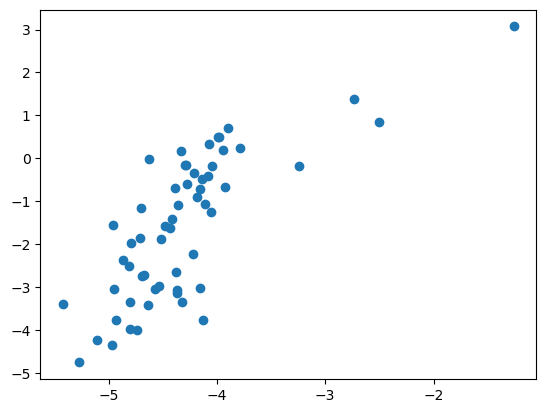

In [27]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [28]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )
NNshifted_phi,madNN=optimal_shift(inf_phases, true_phases)
madNN

0.8179806681459931

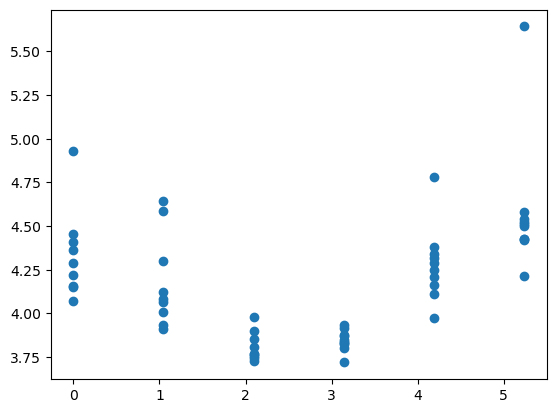

In [29]:
plt.plot(true_phases,NNshifted_phi,'o')

## Adding the "circular" activation function

### Setting the network

In [30]:
#SAME THING BUT USING SEQUENTIAL
'''
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N_Genes, 2,bias=False)
           )
        self.decoder = nn.Sequential(
            nn.Linear(2, N_Genes,bias=False)
           )
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 
        '''

'\nclass CircularEncoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.Linear(N_Genes, 2,bias=False)\n           )\n        self.decoder = nn.Sequential(\n            nn.Linear(2, N_Genes,bias=False)\n           )\n    #fucntion that makes the input flow in the network\n    def forward(self, x):\n        encoded=self.encoder(x) #compress the input\n        encoded_circ=encoded/torch.linalg.norm(encoded)\n        decoded=self.decoder(encoded_circ)\n\n        return decoded #encoded,encoded_circ \n        '

In [31]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
    
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)

        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [32]:
circ_model=CircularEncoder()
criterion2= nn.MSELoss()
optimizer2 = torch.optim.Adam(circ_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)


In [33]:
#recon= reconstruction of the input
num_epochs=300
outputs=[]

for epoch in range(num_epochs):
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=circ_model(input)
    loss=criterion2(recon,input)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
  if (epoch % 10 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 6.149548053741455
epoch  10 Loss 4.223137855529785
epoch  20 Loss 2.7786865234375
epoch  30 Loss 1.8783069849014282
epoch  40 Loss 1.3196088075637817
epoch  50 Loss 0.9458257555961609
epoch  60 Loss 0.670967161655426
epoch  70 Loss 0.4698009788990021
epoch  80 Loss 0.3277948796749115
epoch  90 Loss 0.23121218383312225
epoch  100 Loss 0.16791380941867828
epoch  110 Loss 0.12785592675209045
epoch  120 Loss 0.10328059643507004
epoch  130 Loss 0.08861153572797775
epoch  140 Loss 0.0800875723361969
epoch  150 Loss 0.07527158409357071
epoch  160 Loss 0.07259919494390488
epoch  170 Loss 0.07106812298297882
epoch  180 Loss 0.07006660103797913
epoch  190 Loss 0.06926766782999039
epoch  200 Loss 0.06853503733873367
epoch  210 Loss 0.06783351302146912
epoch  220 Loss 0.06716690957546234
epoch  230 Loss 0.06654787808656693
epoch  240 Loss 0.06598616391420364
epoch  250 Loss 0.0654875636100769
epoch  260 Loss 0.06505347043275833
epoch  270 Loss 0.06468302756547928
epoch  280 Loss 0.06

In [34]:
circ_encoder_base=circ_model.encoder.weight
print(encoder_base)
circ_decoder_baseC=circ_model.decoder.weight
#print(decoder_base)


Parameter containing:
tensor([[ 0.0449, -0.1209, -0.1741, -0.3645, -0.1324, -0.0654,  0.1000, -0.1798,
         -0.1938, -0.0972, -0.3623,  0.1221],
        [-0.2956, -0.1842, -0.1608,  0.0024, -0.2522, -0.1533,  0.0427,  0.3468,
         -0.0734,  0.1039,  0.0656, -0.4716]], requires_grad=True)


After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [35]:
NNphasesC=np.zeros((2,N_Samples))
for sample in range(N_Samples):
  temp=torch.matmul(circ_encoder_base, DATA[:,sample]).detach().numpy()
  NNphasesC[:,sample]=temp
  NNphasesC[:,sample] /= np.linalg.norm(NNphasesC[:,sample])


### Plots

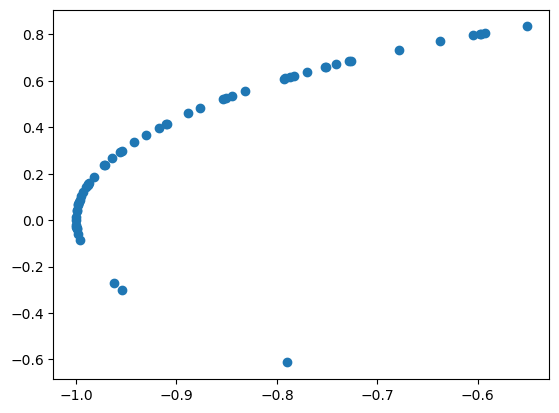

In [36]:
plt.plot(NNphasesC[0,:], NNphasesC[1,:],'o')

In [37]:
inf_phasesC=np.arctan2( NNphasesC[0,:],NNphasesC[1,:] )

NNshifted_phiC,madNNC=optimal_shift(inf_phasesC, true_phases)

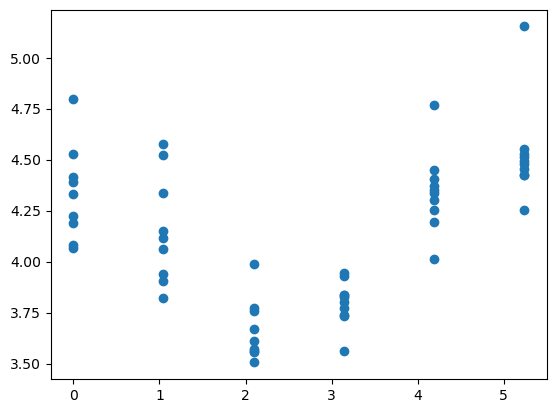

In [38]:
plt.plot(true_phases,NNshifted_phiC,'o')

In [39]:
sum((true_phases-NNshifted_phiC)**2)

290.2534098500308

Outliers really impacat this way of mesuring the goodness of the fit

In [40]:
print('PCA ', sum((true_phases-PCAshifted_phi)**2) )
print('Linear NN ', sum((true_phases-NNshifted_phi)**2) )
print('Circular NN ', sum((true_phases-NNshifted_phiC)**2) )

PCA  248.5143063371627
Linear NN  296.741230676905
Circular NN  290.2534098500308


MAD seems more appropriate


In [42]:
print('PCA ', madPCA )
print('Linear NN ', madNN )
print('circular NN ', madNNC )

PCA  0.33878580216853926
Linear NN  0.8179806681459931
circular NN  0.8113977647913995
